# Probabilites Stock Price Nvidia 
We plot a pdf $f(x)$ for the Nvidia stock, which illustrates how likeley it is that the Nvidia reaches price $x >0 $ at various dates based on various option prices at different strikes $K$ and different expiry dates.

In [1]:
import numpy as np
import yfinance as yf
import matplotlib .pyplot as plt
from matplotlib import cbook, cm
from matplotlib.colors import LightSource   
from matplotlib import cm
from matplotlib.dates import date2num, num2date,DateFormatter
from datetime import datetime
from scipy import stats
from src.PricingFunctions import *
%matplotlib widget

Let us first fix the expiry dates and the strikes which we want to consider in our analysis.

In [2]:
ticker = yf.Ticker("NVDA")
expiry_dates = ticker.options

In [3]:
expiry_dates = expiry_dates

We gather all the strikes, for which we have a listed call and put option at each of the listed expiry dates 

In [4]:
possibleStrikes = set(ticker.option_chain(expiry_dates[0]).calls["strike"])


for i in range(len(expiry_dates)):
    strikes_Call = set(ticker.option_chain(expiry_dates[i]).calls["strike"])
    strikes_Put = set(ticker.option_chain(expiry_dates[i]).puts["strike"])
    possibleStrikes = possibleStrikes.intersection(strikes_Call)
    possibleStrikes = possibleStrikes.intersection(strikes_Put)

possibleStrikes = sorted(list(possibleStrikes))

The CDF for the probability 
$F_T(x) = P(S_T < x ) = {p_T \over p_T + c_T}$
where $S_T$ is the stock price at time $T$ (which needs to be listed in our expiry dates), $p_T$ is our put option market price and $c_T$ is our call option market price.

In [5]:
cdf_how_likeley_Stock_Under_Strike = np.zeros((len(expiry_dates), len(possibleStrikes)))
for i in range(len(expiry_dates)):
    callsForThisExpiry = ticker.option_chain(expiry_dates[i]).calls
    putsForThisExpiry = ticker.option_chain(expiry_dates[i]).puts
    for j in range(len(possibleStrikes)):
        callsPrice =  callsForThisExpiry[callsForThisExpiry['strike'] == possibleStrikes[j]]["lastPrice"].item()
        putPrice =  putsForThisExpiry[putsForThisExpiry['strike'] == possibleStrikes[j]]["lastPrice"].item()
        cdf_how_likeley_Stock_Under_Strike[i,j] = putPrice/(putPrice +callsPrice)


Compute
$\tilde F_T(x) = P(S_T > x) = 1- F_T(x)$

In [6]:
cdf_how_likeley_Stock_Above_Strike = 1 - cdf_how_likeley_Stock_Under_Strike

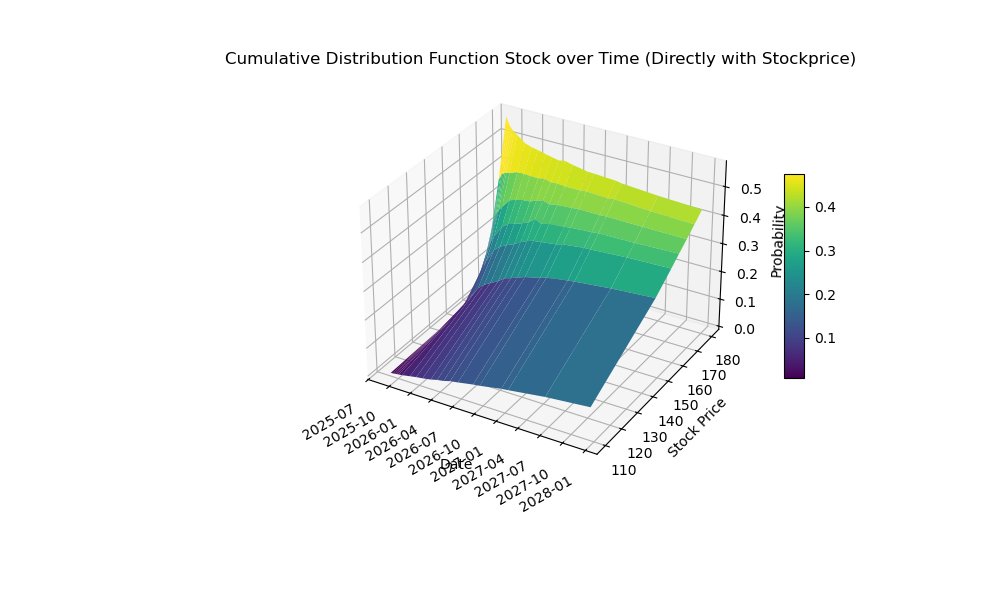

In [7]:
x = np.array(expiry_dates)

y = possibleStrikes

x_dates = np.array([datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, cdf_how_likeley_Stock_Under_Strike, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Cumulative Distribution Function Stock over Time (Directly with Stockprice)")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Probability")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

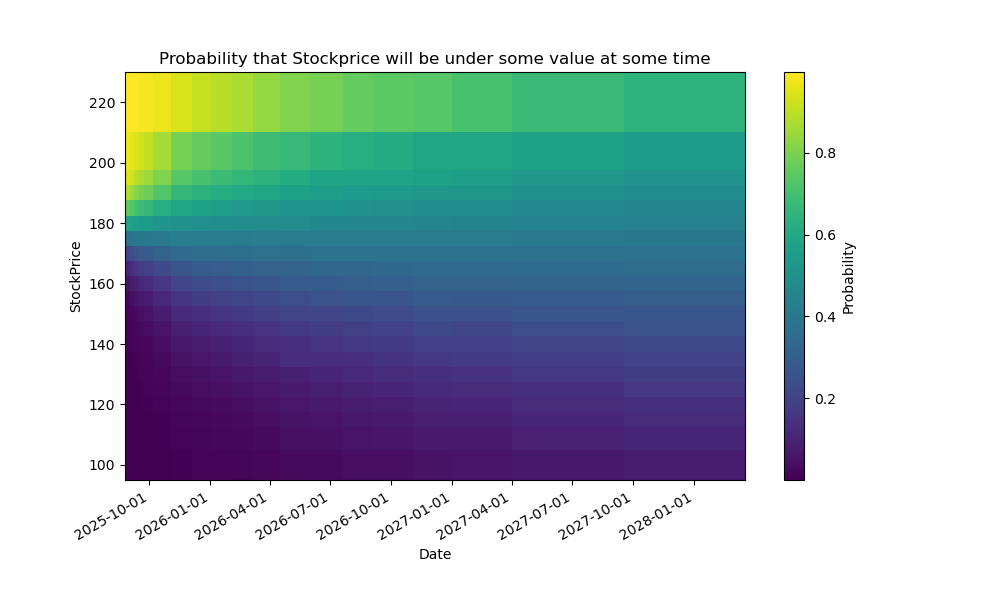

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

c = ax.pcolormesh(X, Y, cdf_how_likeley_Stock_Under_Strike, cmap="viridis", shading="auto")

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

ax.set_title("Probability that Stockprice will be under some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("StockPrice")
plt.colorbar(c, ax=ax, label="Probability")

plt.show()

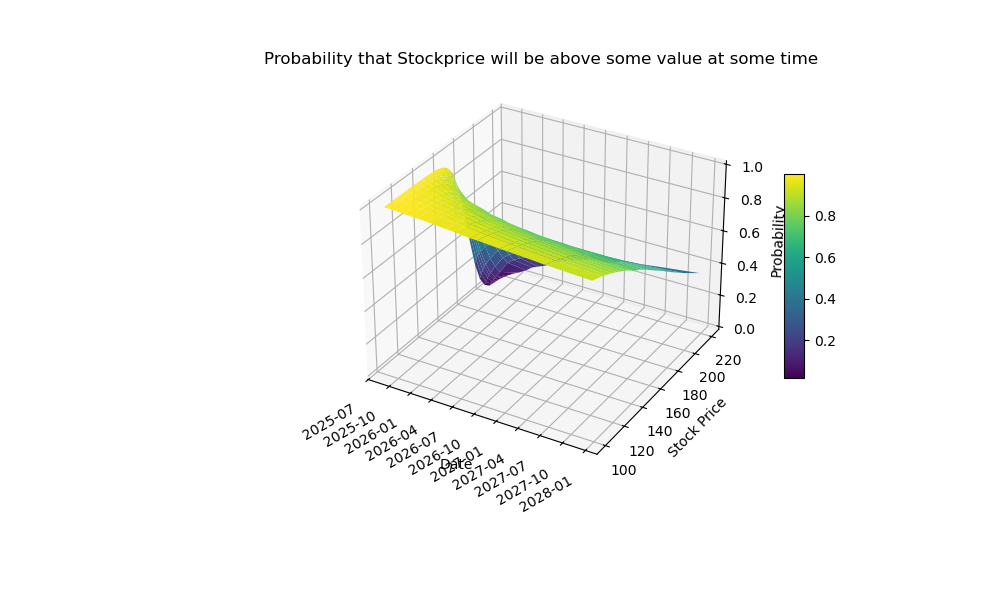

In [ ]:
x = np.array(expiry_dates)

y = possibleStrikes


x_dates = np.array([datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, cdf_how_likeley_Stock_Above_Strike, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Probability that Stockprice will be above some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Probability")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

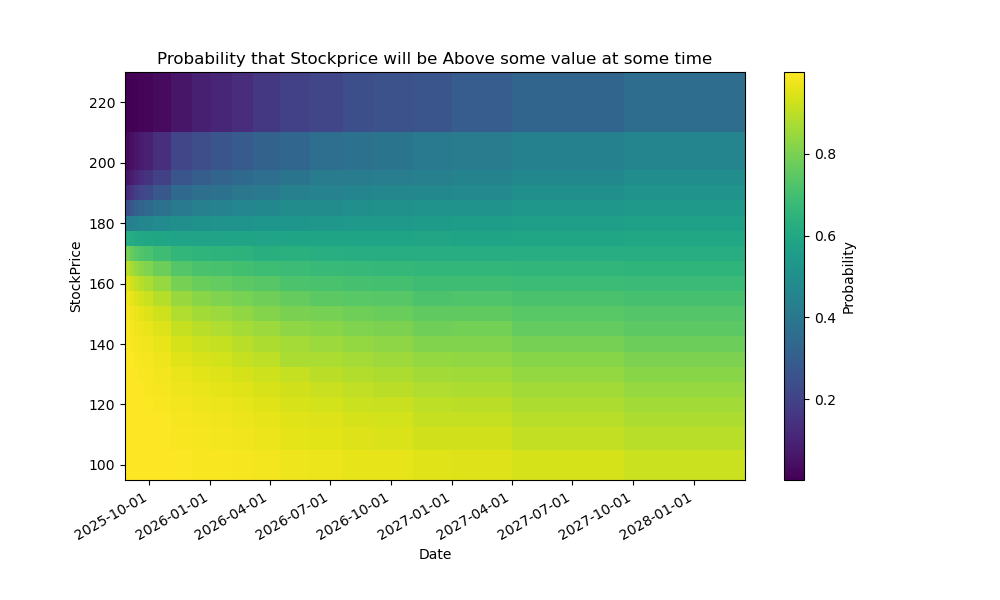

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))


c = ax.pcolormesh(X, Y, cdf_how_likeley_Stock_Above_Strike, cmap="viridis", shading="auto")

ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

ax.set_title("Probability that Stockprice will be Above some value at some time")
ax.set_xlabel("Date")
ax.set_ylabel("StockPrice")
plt.colorbar(c, ax=ax, label="Probability")

plt.show()

# Breeden-Litzenberg
We compare our results from above with the probability distribution which is induced by the Breeden-Litzenberg formula, i.e. under Black Scholes we have

$f_{S_T} (K) = exp(r \tau) \cdot {\partial ^2 c \over \partial K^2} $

where $c$ is the price of a european option and the rest is as usual.

Let's see which implied volatility we should choose

In [8]:
IVs = []
for i in range(len(expiry_dates)):
    calls = ticker.option_chain(expiry_dates[i]).calls
    puts = ticker.option_chain(expiry_dates[i]).puts
    calls_IVs = calls["impliedVolatility"].to_list()
    puts_IVs = puts["impliedVolatility"].to_list()
    IVs = IVs + calls_IVs + puts_IVs

iv_mean = np.mean(IVs)

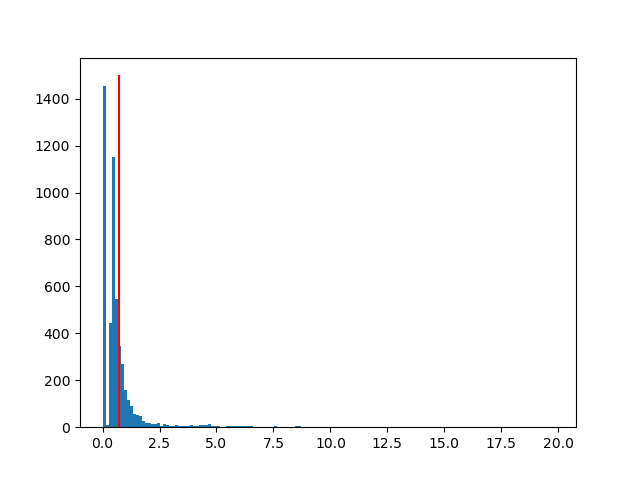

In [ ]:
plt.clf()
plt.hist(IVs, bins=150)

plt.vlines(iv_mean, ymin=0, ymax=1500, colors="red")
plt.title("Histogram implied volatilites observed for different options")
plt.show()

In [26]:
print(f"The mean implied volatility is {round(iv_mean,3 )}, which we will use in our computations.")

The mean implied volatility is 0.706, which we will use in our computations.


In [154]:
S0 = ticker.history(period="1d")['Close'].iloc[-1]
r = 0.0426  
sigma = iv_mean     

In [156]:
maxT = (datetime.strptime(expiry_dates[-1], "%Y-%m-%d").date() - datetime.now().date()).days / 365

In [157]:
minK = min(possibleStrikes)
maxK = max(possibleStrikes)

We want to do finite differences wrt K over all time periods. We need a gridsize for K

In [158]:
N = 1000
pdf_breedenLitzenberg = np.zeros((len(expiry_dates), N))
h = (maxK - minK) / N

In [159]:
for i in range(len(expiry_dates)):
    daysLeft = (datetime.strptime(expiry_dates[i], "%Y-%m-%d").date() - datetime.now().date()).days
    T = daysLeft /365
    c_Minus = analyticEuropeanCall_BS(r, 0, T, minK - h, S0, sigma)
    c_At = analyticEuropeanCall_BS(r, 0, T, minK , S0, sigma)
    c_Plus = analyticEuropeanCall_BS(r, 0, T, minK + h, S0, sigma)
    for k in range(N):
        pdf_breedenLitzenberg[i, k] = (c_Plus - 2*c_At + c_Minus) / (h**2)
        c_Minus = c_At
        c_At = c_Plus
        c_Plus = analyticEuropeanCall_BS(r, 0, T, minK + h*(k+2), S0, sigma)
    
    pdf_breedenLitzenberg[i, :] = pdf_breedenLitzenberg[i, :] * np.exp(r*T)

In [160]:
k_Ax = np.arange(minK, maxK, h)

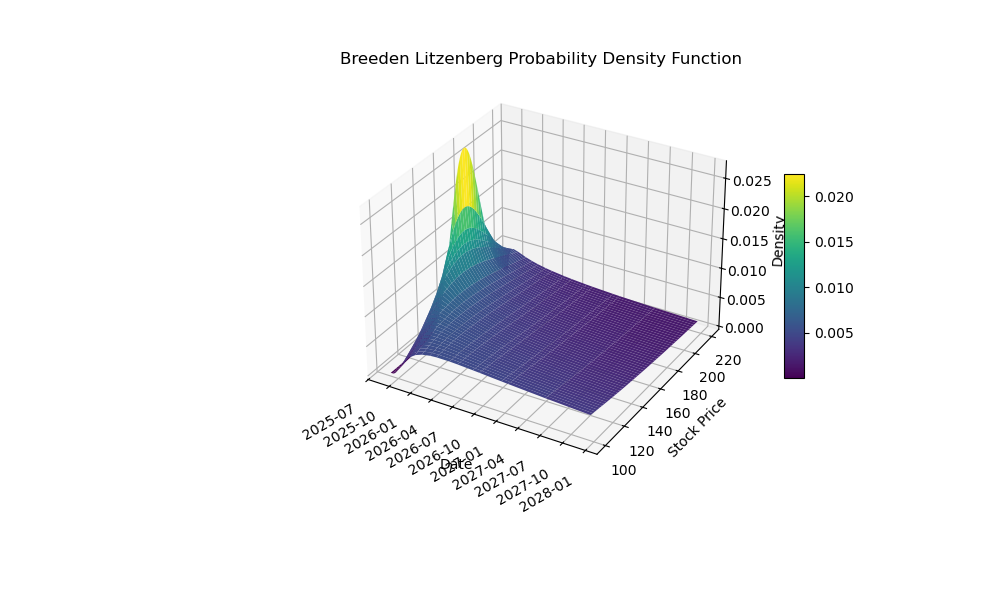

In [161]:
plt.clf()
x = np.array(expiry_dates)

y = k_Ax

x_dates = np.array([datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, pdf_breedenLitzenberg, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Breeden Litzenberg Probability Density Function")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Density")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [162]:
cdf_Put_BreedenLitzenberg = np.zeros_like(pdf_breedenLitzenberg)

for i in range(len(expiry_dates)):
    sumDensities = 0
    for k in range(N):
        sumDensities += pdf_breedenLitzenberg[i,k]
        cdf_Put_BreedenLitzenberg[i,k] = sumDensities * h

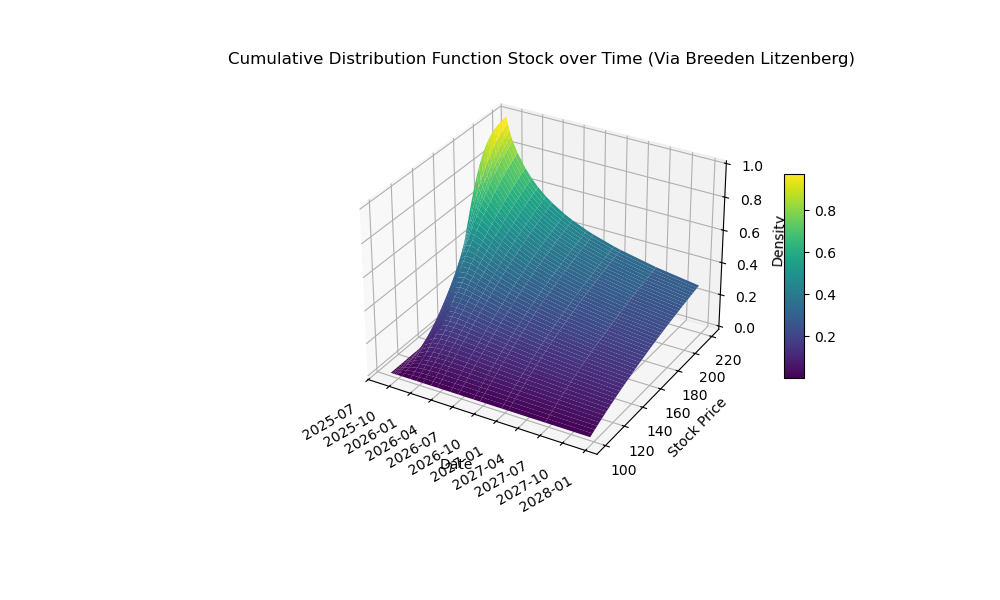

In [163]:
plt.clf()
x = np.array(expiry_dates)

y = k_Ax

x_dates = np.array([datetime.strptime(d, "%Y-%m-%d") for d in expiry_dates])
x_num = date2num(x_dates)
X, Y = np.meshgrid(x_num, y, indexing="ij")  # shape (N,M)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, cdf_Put_BreedenLitzenberg, cmap=cm.viridis)

ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Cumulative Distribution Function Stock over Time (Via Breeden Litzenberg)")
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Density")

plt.colorbar(surf, shrink=0.5, aspect=10)
plt.show()